In [1]:
import tensorflow as tf
from tensorflow.python.client import device_lib
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, r2_score

Using TensorFlow backend.


In [2]:
#Checking for GPU
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1070920214371066057
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1469199154
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18246953556560536973
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
#Importing the Dataset with TDS
dataset = pd.read_csv('2021_10_31_cleaned_lake_dataset_with_tds.csv', header=0, index_col=0)
dataset = dataset.rename(columns={'actual_conductivity':'cond', 'total_dissolved_solids':'tds', 'do_concentration':'do', 'turbidity':'turb', 'chl-a_concentration':'chl-a', 'temperature':'temp'})
dataset = dataset[['temp', 'cond', 'do', 'tds', 'turb', 'chl-a']]
dataset.sort_index()
dataset.head()

,temp,cond,do,tds,turb,chl-a
datetime,,,,,,
2019-02-20 12:00:00,29.55674,92.12651,6.491213,0.055088,32.86783,39.64875
2019-02-20 12:10:00,29.59175,92.22813,6.724226,0.055115,24.30492,40.57396
2019-02-20 12:20:00,29.57693,91.93182,6.677357,0.054952,47.46174,40.88269
2019-02-20 12:30:00,29.63118,92.45161,7.540924,0.055210,55.04100,46.67803
2019-02-20 12:40:00,29.64378,92.78736,7.629431,0.055398,26.58170,47.05107


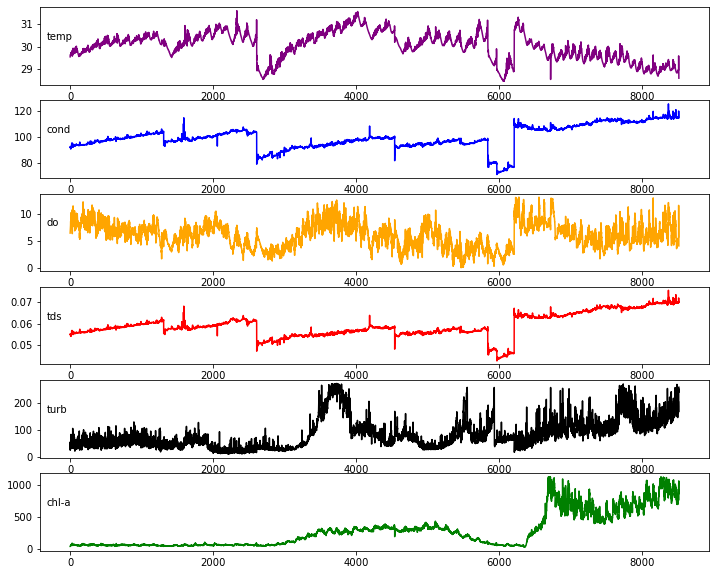

In [9]:
#visualizing subplots of the data
values = dataset.values
groups = [0,1,2,3,4,5]
colors=['purple', 'blue', 'orange',  'red', 'black', 'green']
column_names = ['temp','cond', 'do', 'tds','turb', 'chl-a']
i = 1

# plt.figure()
plt.figure(figsize=(12,10))
for group  in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:,group], color = colors[i-1])
    plt.title(dataset.columns[group], x=0.01, y=0.50, loc='left', fontsize = 10)
    i += 1
plt.show()